In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf 
import matplotlib.dates as mdates

In [7]:
dfxgboost= pd.read_csv('xgboost_results_dump.csv')
dfarima = pd.read_csv('xgboost_results_dump.csv')
#print(dfarima.head())
#print(dfxgboost.head())

In [8]:
dfxgboost.rename(columns={'Unnamed: 0':'date'},inplace = True)
dfarima.rename(columns={'Unnamed: 0':'date'},inplace = True)
dfsor = pd.merge(dfxgboost, dfarima, on = 'date', suffixes = ('_xgboost','_arima'))
#print(dfsor.head())

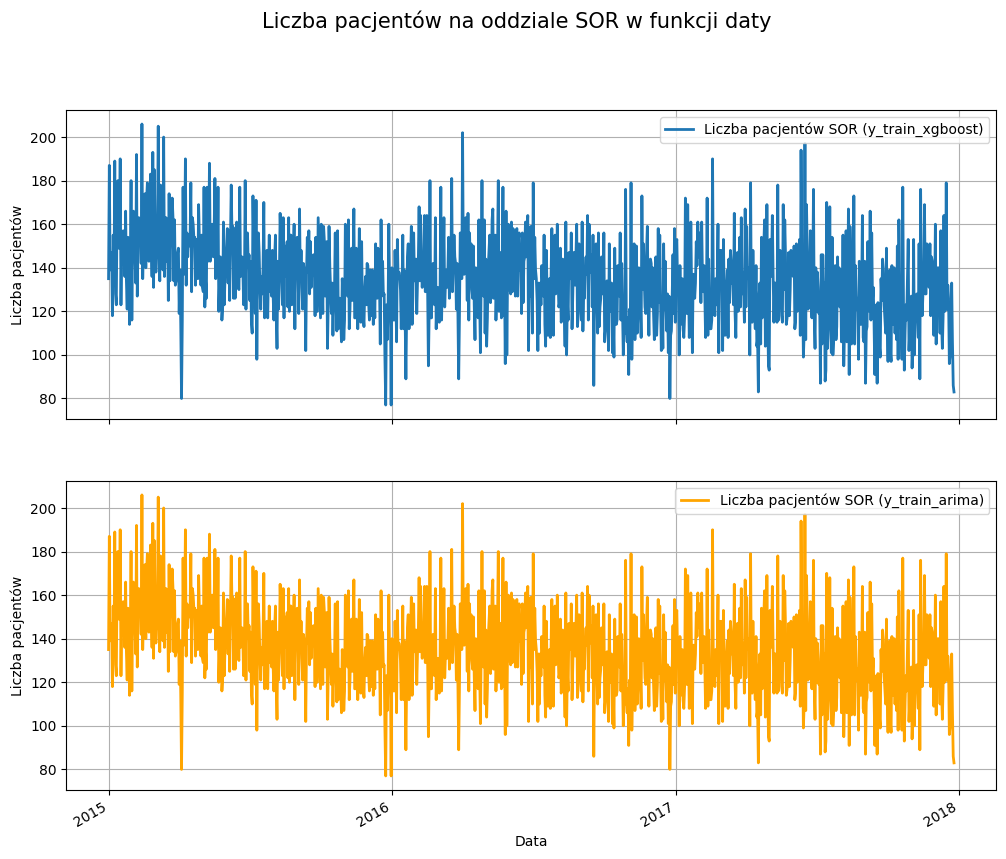

In [22]:
dfsor['date'] = pd.to_datetime(dfsor['date'])

y_values_xgboost = dfsor['y_train_xgboost'].dropna()
y_values_arima = dfsor['y_train_arima'].dropna()
dates_xgboost = dfsor['date'][y_values_xgboost.index]
dates_arima = dfsor['date'][y_values_arima.index]

date_locator = mdates.YearLocator(1)
date_formatter = mdates.DateFormatter('%Y')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(dates_xgboost, y_values_xgboost, lw=2, label="Liczba pacjentów SOR (y_train_xgboost)")
ax1.xaxis.set_major_locator(date_locator)
ax1.xaxis.set_major_formatter(date_formatter)
ax1.set_ylabel("Liczba pacjentów")
ax1.set_xlabel("Data")
ax1.legend()
ax1.grid(True)

ax2.plot(dates_arima, y_values_arima, lw=2, label="Liczba pacjentów SOR (y_train_arima)", color='orange')
ax2.xaxis.set_major_locator(date_locator)
ax2.xaxis.set_major_formatter(date_formatter)
ax2.set_ylabel("Liczba pacjentów")
ax2.set_xlabel("Data")
ax2.legend()
ax2.grid(True)

fig.suptitle("Liczba pacjentów na oddziale SOR w funkcji daty", fontsize=15)
fig.autofmt_xdate()
plt.show()